In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models

In [2]:
df = pd.read_csv('preprocessed_df.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
vec = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf = vec.fit_transform(df['preprocessed_text'])

In [5]:
feature_names = vec.get_feature_names_out()

In [6]:
#Set random state
random_state = 696

In [7]:
#get the feature ready for the coherence model

df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: x.split())
texts = df['preprocessed_text'].tolist()
dictionary = corpora.Dictionary(texts)

In [8]:
num_top_words = 100
coherence_scores = []
best_avg_coherence = 0
best_model = None
best_W = None
best_H = None

for num_topics in range(2,11):
    nmf = NMF(n_components = num_topics, 
                  max_iter = 200, init = 'nndsvd', random_state = random_state)
    W = nmf.fit_transform(tfidf)
    H = nmf.components_
    
    topics = []
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[-num_top_words:][::-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append(top_features)
        
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    avg_c = coherence_model.get_coherence()
    coherence_scores.append(avg_c)
    
    if avg_c > best_avg_coherence:
        best_avg_coherence = avg_c
        best_model = nmf
        best_W = W
        best_H = H

/home/qianfu/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/qianfu/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [9]:
best_model

NMF(init='nndsvd', n_components=10, random_state=696)

In [10]:
with open('out/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [11]:
coherence_scores

[0.3470058271772469,
 0.36834263644077286,
 0.35041435750632727,
 0.3674657430424791,
 0.3958608813253665,
 0.3988099377494648,
 0.4065147783386126,
 0.4058151736220475,
 0.42632352173416327]

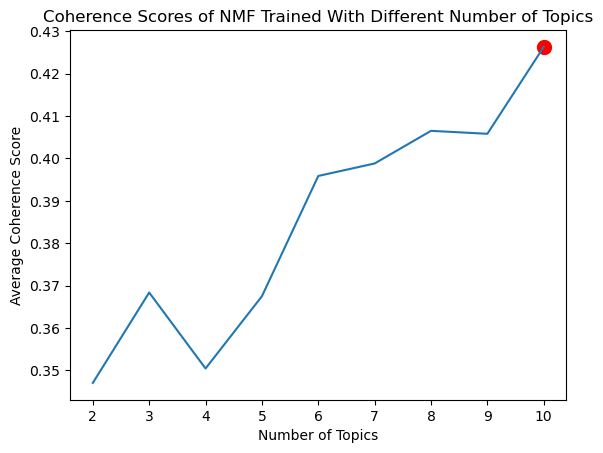

In [12]:
plt.plot(np.arange(2,11), coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.title('Coherence Scores of NMF Trained With Different Number of Topics')
plt.scatter(best_model.n_components, coherence_scores[best_model.n_components -2], c='red', marker='o', s=100)

In [13]:
#print out the top 50 words for each topic

num_top_words = 50

for topic_idx, topic in enumerate(best_H):
    print(f"Topic {topic_idx + 1}:")
    top_features_ind = topic.argsort()[-num_top_words:][::-1]  
    top_features = [feature_names[i] for i in top_features_ind]
    top_features_str = ", ".join(top_features)
    print(top_features_str)


Topic 1:
get, go, work, time, day, sleep, back, start, job, week, every, try, need, hour, last, thing, night, well, keep, month, bad, hard, home, really, year, wake, long, even, one, make, come, use, do, today, could, bed, ill, still, first, put, able, much, class, end, help, minute, leave, school, next, new
Topic 2:
ocd, compulsion, obsession, bad, fear, anxiety, theme, diagnose, help, therapist, contamination, symptom, erp, harm, thing, therapy, disorder, suffer, make, check, hand, event, think, real, mental, deal, also, obsess, reassurance, wash, worry, treatment, pocd, false, touch, illness, since, ritual, wonder, past, go, certain, please, something, hi, might, health, cause, develop, type
Topic 3:
adhd, diagnose, help, diagnosis, symptom, medication, get, doctor, struggle, psychiatrist, year, school, test, anxiety, also, lot, issue, med, appointment, depression, focus, find, need, recently, work, well, thank, disorder, really, read, therapist, mental, learn, since, wonder, therap

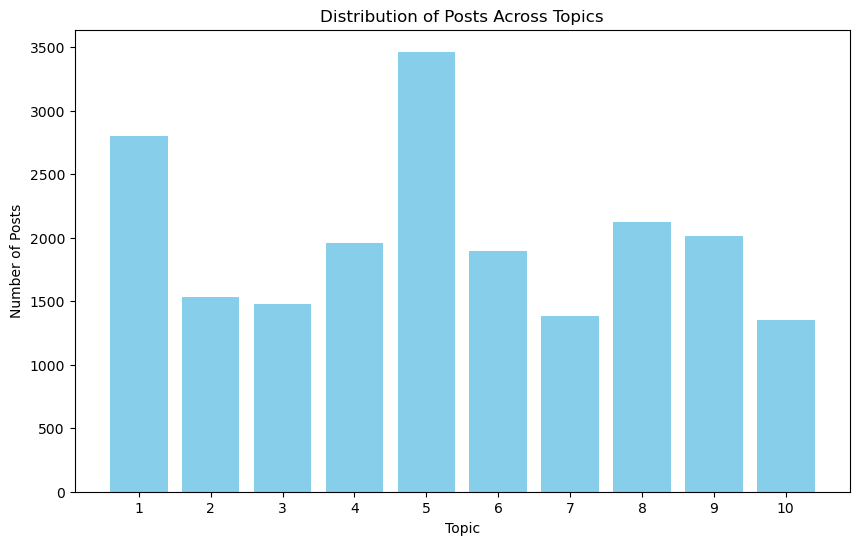

In [14]:
#get the dominant topic for each post
dominant_topics = np.argmax(best_W, axis=1)
#count the posts for each topic
posts_per_topic = np.bincount(dominant_topics, minlength=best_model.n_components)

# visual the distribution
plt.figure(figsize=(10, 6))
topics = range(1, best_model.n_components + 1)
plt.bar(topics, posts_per_topic, color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Number of Posts')
plt.title('Distribution of Posts Across Topics')
plt.xticks(topics) 
plt.show()